<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_MLP_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597:- Multi-Layer Perceptron

# Case 1: 

Using default batch size without softmax activation in output layer, without any regularization to determine the Categorical Cross-Entropy of test dataset and determine the accuracy of default model in GPU,TPU,CPU and on default mode.

## Load the libraries

In [1]:
#Core Libraries 
import os
import numpy as np
import time
import tensorflow as tf
#Libraries for data featching
from sklearn.datasets import fetch_openml
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
np.random.seed(5997)
tf.random.set_seed(5997)

In [2]:
x, y = fetch_openml(name="Fashion-MNIST", version=1, return_X_y=True)
# x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=98)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Get number of Gpu's and id's in the system or else you can also use Nvidia-smi in command prompt.

## Define the input layer size, hidden layers size and output layer size

In [8]:
size_input = 784
size_hidden = [128,64]
size_output = 10
number_of_train_examples = 60000
number_of_test_examples = 10000

In [9]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

## Build MLP using Eager Execution

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

## Train Model

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    # Calculate accuracy
    preds = mlp_on_cpu.forward(inputs)
    pred = preds
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)
    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical_Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical_Cross-Entropy:= 0.041097118730304624
Number of Epoch = 1 - Accuracy:= 0.4942854873272552
Number of Epoch = 2 - Categorical_Cross-Entropy:= 0.0403126107865021
Number of Epoch = 2 - Accuracy:= 0.4861341524524849
Number of Epoch = 3 - Categorical_Cross-Entropy:= 0.03900169462316176
Number of Epoch = 3 - Accuracy:= 0.48361331074177716
Number of Epoch = 4 - Categorical_Cross-Entropy:= 0.03715450613839286
Number of Epoch = 4 - Accuracy:= 0.48562997128783153
Number of Epoch = 5 - Categorical_Cross-Entropy:= 0.035235421316964284
Number of Epoch = 5 - Accuracy:= 0.48453758944984243
Number of Epoch = 6 - Categorical_Cross-Entropy:= 0.03348953477875525
Number of Epoch = 6 - Accuracy:= 0.4856297789501543
Number of Epoch = 7 - Categorical_Cross-Entropy:= 0.03266332802652311
Number of Epoch = 7 - Accuracy:= 0.4847896800321691
Number of Epoch = 8 - Categorical_Cross-Entropy:= 0.031923522436318276
Number of Epoch = 8 - Accuracy:= 0.4844536019974396
Number of Epoch = 9

In [ ]:
# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    pred = preds


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.0332476242450105
Number of Epoch = 1 - Accuracy:= 0.5566388298483456
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.03144235819327731
Number of Epoch = 2 - Accuracy:= 0.5566198525308561
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.03015508058692227
Number of Epoch = 3 - Accuracy:= 0.5564520058511685
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.028971817144826682
Number of Epoch = 4 - Accuracy:= 0.5563586579651392
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.027486933347557772
Number of Epoch = 5 - Accuracy:= 0.5562839027212447
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.026605023552389705
Number of Epoch = 6 - Accuracy:= 0.5561906189477744
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.02674112887342437
Number of Epoch = 7 - Accuracy:= 0.5563213444557511
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.026695168887867646
Number of Epoch = 8 - Accuracy:= 0.556097271061745
Number of Epoch = 9 - 

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(outputs, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.03312938837644433
Number of Epoch = 1 - Accuracy:= 0.5457983577952665
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.03469033531381303
Number of Epoch = 2 - Accuracy:= 0.546470065076812
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.035857598312762605
Number of Epoch = 3 - Accuracy:= 0.54848717441078
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.03699810431985294
Number of Epoch = 4 - Accuracy:= 0.5501679492597821
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.037642020089285716
Number of Epoch = 5 - Accuracy:= 0.5526049317432051
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.03850659384847689
Number of Epoch = 6 - Accuracy:= 0.5552098891314338
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.04000443146008403
Number of Epoch = 7 - Accuracy:= 0.556806612415474
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.041613978794642854
Number of Epoch = 8 - Accuracy:= 0.5578990263097426
Number of Epoch = 9 - Cat

## plot

In [1]:
acc = [0.54579,0.54647,0.54848,0.55016,0.55260,0.55520,0.55680,0.55789,0.55495,0.55739]

In [2]:
loss = [0.04330,0.043157,0.041613,0.040004,0.03850,0.03764,0.03699,0.03585,0.03469,0.03312]

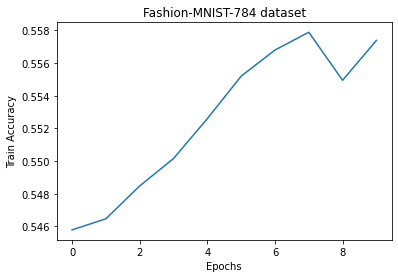

In [3]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('Fashion-MNIST-784 dataset')
plt.plot(acc)
# plt.plot(loss)

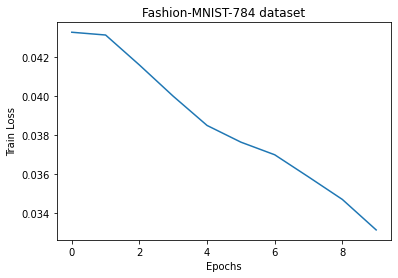

In [4]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Fashion-MNIST-784 dataset')
plt.plot(loss)

### test plot 10 round

In [5]:
acct = [55.73, 54.45, 47.89, 48.51, 52.09, 51.85, 55.01, 51.15, 46.88, 45.79]

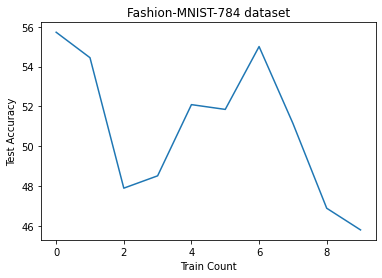

In [7]:
from matplotlib import pyplot as plt
plt.xlabel('Train Count')
plt.ylabel('Test Accuracy')
plt.title('Fashion-MNIST-784 dataset')
plt.plot(acct)
# plt.plot(loss)

In [ ]:
#TPU mode
mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='tpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    pred = tf.nn.softmax(preds)  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.03263728088891807
Number of Epoch = 1 - Accuracy:= 0.5466384246569721
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.033251499720982146
Number of Epoch = 2 - Accuracy:= 0.5473110936269039
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.03295071436777836
Number of Epoch = 3 - Accuracy:= 0.5475629918715533
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.03217592486213235
Number of Epoch = 4 - Accuracy:= 0.5487395214433429
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.03203352727809874
Number of Epoch = 5 - Accuracy:= 0.5500838976948201
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.032603585379464284
Number of Epoch = 6 - Accuracy:= 0.5497477555475315
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.033028145926339285
Number of Epoch = 7 - Accuracy:= 0.5496638322076878
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.032133341813287815
Number of Epoch = 8 - Accuracy:= 0.5631932491013983
Number of Epoch = 9 

## One Step Inference

In [51]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0416
Test Accuracy: 0.5524


# Case 2

In this case, the implementation is done using an additional layer of softmax on the top of the output layer. Softmax will Using default batch size with softmax activation in output layer, without any regularization. Softmax predict a multinomial probability distribution. That is, softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.

In [4]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [5]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [6]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = preds  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = preds
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

# Case 3

In this case, the implementation is done by adding a dropout layer after every MLP layer. So we have one Dropout penalty/regularization layers added after the activation of layer of each MLP layer.

In [17]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [18]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [19]:
# Set number of epochs
NUM_EPOCHS = 10

In [20]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) 
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.03431943646599265
Number of Epoch = 1 - Accuracy:= 0.6612606529428178
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.03377833262211134
Number of Epoch = 2 - Accuracy:= 0.662773324661896
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.03347369641215861
Number of Epoch = 3 - Accuracy:= 0.6641178932510504
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.033099326253939076
Number of Epoch = 4 - Accuracy:= 0.6667229147518382
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.03262696543461135
Number of Epoch = 5 - Accuracy:= 0.6664706318318343
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.032015625
Number of Epoch = 6 - Accuracy:= 0.6678992519859507
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.03169316857602416
Number of Epoch = 7 - Accuracy:= 0.6703361703568146
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.03148836536567752
Number of Epoch = 8 - Accuracy:= 0.6709244671989889
Number of Epoch = 9 - Categorica

In [52]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = preds
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0316
Test Accuracy: 0.6724


## Plot

In [12]:
acc = [0.66126,0.66277,0.66411,0.66672,0.66647,0.66789,0.67033,0.67092,0.67159,0.675378]

In [13]:
loss = [0.0343194,0.033778,0.033473,0.033099,0.032626,0.032015,0.031693,0.031488,0.031165,0.03097298]

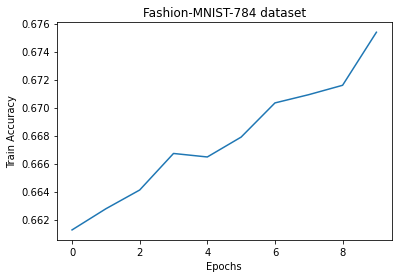

In [14]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('Fashion-MNIST-784 dataset')
plt.plot(acc)
# plt.plot(loss)

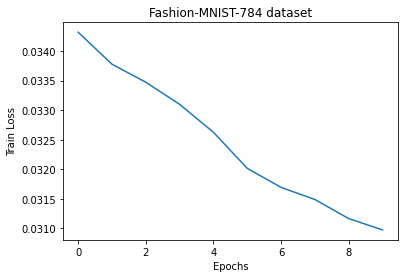

In [15]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Fashion-MNIST-784 dataset')
plt.plot(loss)

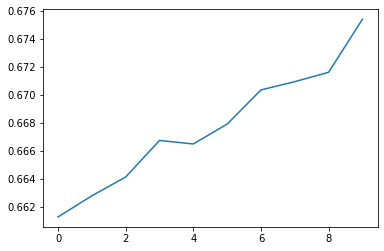

In [7]:
from matplotlib import pyplot as plt
plt.plot(acc)
# plt.plot(loss)

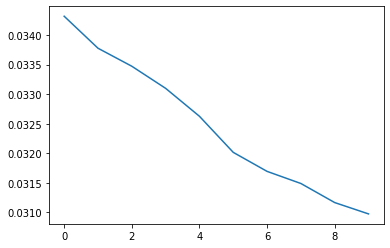

In [8]:
plt.plot(loss)

# Case 4

In this case, the implementation is done by adding regularizing function by applying L1 penalty/regularization.

In [22]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [23]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3)) # L1 = absolute sum of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.03 * L1 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [24]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = preds


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.034886956735819326
Number of Epoch = 1 - Accuracy:= 0.6605883686482406
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.03455271385898109
Number of Epoch = 2 - Accuracy:= 0.6628572480017398
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.034188443736869745
Number of Epoch = 3 - Accuracy:= 0.6678993160985097
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.03385162609965861
Number of Epoch = 4 - Accuracy:= 0.6699162972073596
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.03283074079241072
Number of Epoch = 5 - Accuracy:= 0.6753778537782301
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.03218716148568802
Number of Epoch = 6 - Accuracy:= 0.6805884096802784
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.031738943917410715
Number of Epoch = 7 - Accuracy:= 0.6816809517996651
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.031482901949842435
Number of Epoch = 8 - Accuracy:= 0.6837816639106815
Number of Epoch = 9 

In [53]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = preds
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0305
Test Accuracy: 0.6907


## Plot

In [8]:
acc = [0.660588,0.662857,0.667899,0.669916,0.675377,0.680588,0.681680,0.6837816,0.6847895,0.6909245]

In [9]:
loss = [0.0348869,0.0345527,0.0341884,0.033851,0.03283,0.0321871,0.031482,0.031241,0.030917]

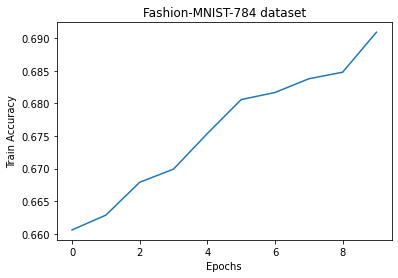

In [10]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('Fashion-MNIST-784 dataset')
plt.plot(acc)
# plt.plot(loss)

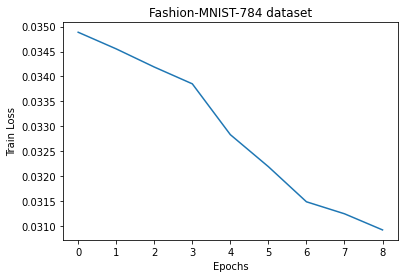

In [11]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Fashion-MNIST-784 dataset')
plt.plot(loss)

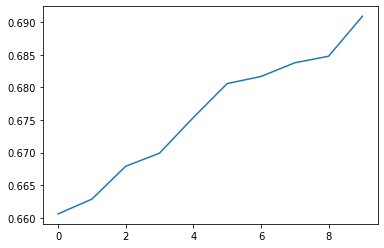

In [11]:
from matplotlib import pyplot as plt
plt.plot(acc)
# plt.plot(loss)

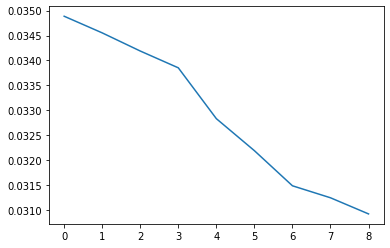

In [12]:
plt.plot(loss)

# Case 5


In this case, the implementation is done by adding regularizing function by applying L2 penalty/regularization.

In [28]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [29]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [30]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(260)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = preds  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*1000))
time_taken = time.time() - time_start
print('\n')
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = preds
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0785
Test Accuracy: 0.6142


# Case 6

In this case, the implementation is done by adding regularizing function by applying a combination of l1 and l2 penalty/regularization which is called Elastic Net Regularization.

In [42]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [43]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3)) # L1 = absolute sum of weights (Also known as Lasso)
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.02*L1 + 0.03 * L2 # Lambda/Regularization Parameter for L1 = 0.02, Lambda/Regularization Parameter for L2 = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [44]:
# Set number of epochs
NUM_EPOCHS = 10

In [48]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = preds  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.043651137408088236
Number of Epoch = 1 - Accuracy:= 0.6537064624433758
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.04238751887473739
Number of Epoch = 2 - Accuracy:= 0.6527312463071165
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.04091924074317227
Number of Epoch = 3 - Accuracy:= 0.65274573574547
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.04004305081407563
Number of Epoch = 4 - Accuracy:= 0.6545767904329701
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.03930364118303571
Number of Epoch = 5 - Accuracy:= 0.655987266732865
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.0387056771927521
Number of Epoch = 6 - Accuracy:= 0.6580282900513721
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.0384071814272584
Number of Epoch = 7 - Accuracy:= 0.661989548627068
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.03807140395220588
Number of Epoch = 8 - Accuracy:= 0.6641958541228992
Number of Epoch = 9 - Categor

In [50]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = preds
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.03642
Test Accuracy: 0.6690


# Case 7

Hyper Parameter Optimization for Batch Size using Trial and Error


## Batch Size = 20 (default)

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(outputs, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.03312938837644433
Number of Epoch = 1 - Accuracy:= 0.5457983577952665
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.03469033531381303
Number of Epoch = 2 - Accuracy:= 0.546470065076812
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.035857598312762605
Number of Epoch = 3 - Accuracy:= 0.54848717441078
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.03699810431985294
Number of Epoch = 4 - Accuracy:= 0.5501679492597821
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.037642020089285716
Number of Epoch = 5 - Accuracy:= 0.5526049317432051
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.03850659384847689
Number of Epoch = 6 - Accuracy:= 0.5552098891314338
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.04000443146008403
Number of Epoch = 7 - Accuracy:= 0.556806612415474
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.041613978794642854
Number of Epoch = 8 - Accuracy:= 0.5578990263097426
Number of Epoch = 9 - Cat

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0416
Test Accuracy: 0.5524


## Batch Size = 256

In [54]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [59]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(236)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*1000))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.031110755728072478
Number of Epoch = 1 - Accuracy:= 0.44425900242909666
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.030868047121192226
Number of Epoch = 2 - Accuracy:= 0.4434451576040572
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.030586840204831933
Number of Epoch = 3 - Accuracy:= 0.4422345842633929
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.030265723476890757
Number of Epoch = 4 - Accuracy:= 0.4430788504977186
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.029604986623555672
Number of Epoch = 5 - Accuracy:= 0.44142045093183757
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.028931025144432774
Number of Epoch = 6 - Accuracy:= 0.4418073702259224
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.028478175059086133
Number of Epoch = 7 - Accuracy:= 0.44053553733505124
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.02799246446625525
Number of Epoch = 8 - Accuracy:= 0.44134963861032694
Number of Epo

In [60]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.2854
Test Accuracy: 0.4403


# Case 8

Hyper Parameter Optimization for Optimizers - AdaM instead of SGD using Trial and Error

## SGD

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(outputs, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.03312938837644433
Number of Epoch = 1 - Accuracy:= 0.5457983577952665
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.03469033531381303
Number of Epoch = 2 - Accuracy:= 0.546470065076812
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.035857598312762605
Number of Epoch = 3 - Accuracy:= 0.54848717441078
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.03699810431985294
Number of Epoch = 4 - Accuracy:= 0.5501679492597821
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.037642020089285716
Number of Epoch = 5 - Accuracy:= 0.5526049317432051
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.03850659384847689
Number of Epoch = 6 - Accuracy:= 0.5552098891314338
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.04000443146008403
Number of Epoch = 7 - Accuracy:= 0.556806612415474
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.041613978794642854
Number of Epoch = 8 - Accuracy:= 0.5578990263097426
Number of Epoch = 9 - Cat

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0416
Test Accuracy: 0.5524


## Adam

In [61]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [63]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = preds


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.03398519153755252
Number of Epoch = 1 - Accuracy:= 0.507394934902672
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.040906504398634455
Number of Epoch = 2 - Accuracy:= 0.5638654692834165
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.04176212907037815
Number of Epoch = 3 - Accuracy:= 0.6511765808618368
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.04323806788340336
Number of Epoch = 4 - Accuracy:= 0.7099999179359243
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.042265752199317226
Number of Epoch = 5 - Accuracy:= 0.6126892346293986
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.0426512112657563
Number of Epoch = 6 - Accuracy:= 0.5460503842650342
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.043051532136292016
Number of Epoch = 7 - Accuracy:= 0.5386553211372439
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.04262109785320378
Number of Epoch = 8 - Accuracy:= 0.5462183591698399
Number of Epoch = 9 - C

In [65]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0411
Test Accuracy: 0.5684


# Case 9

Hyper Parameter Optimization for Learning Rate using Trial and Error

## 1e-4



In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(outputs, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.03312938837644433
Number of Epoch = 1 - Accuracy:= 0.5457983577952665
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.03469033531381303
Number of Epoch = 2 - Accuracy:= 0.546470065076812
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.035857598312762605
Number of Epoch = 3 - Accuracy:= 0.54848717441078
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.03699810431985294
Number of Epoch = 4 - Accuracy:= 0.5501679492597821
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.037642020089285716
Number of Epoch = 5 - Accuracy:= 0.5526049317432051
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.03850659384847689
Number of Epoch = 6 - Accuracy:= 0.5552098891314338
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.04000443146008403
Number of Epoch = 7 - Accuracy:= 0.556806612415474
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.041613978794642854
Number of Epoch = 8 - Accuracy:= 0.5578990263097426
Number of Epoch = 9 - Cat

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0416
Test Accuracy: 0.5524


## 1e-3

In [66]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [69]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(250)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*1000))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.02466534269957983
Number of Epoch = 1 - Accuracy:= 0.47314276815462514
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.0241364520417542
Number of Epoch = 2 - Accuracy:= 0.47549576318564535
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.024041575712316177
Number of Epoch = 3 - Accuracy:= 0.47556292109128806
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.02442272025997899
Number of Epoch = 4 - Accuracy:= 0.4765041255149521
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.02492714351365546
Number of Epoch = 5 - Accuracy:= 0.4746889386858259
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.025440380449054622
Number of Epoch = 6 - Accuracy:= 0.4723360398236443
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.026370609571953783
Number of Epoch = 7 - Accuracy:= 0.4695797447396927
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.027249503512342437
Number of Epoch = 8 - Accuracy:= 0.46823517615053833
Number of Epoch =

In [70]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0284
Test Accuracy: 0.4698


## ie-5

In [71]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [73]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.028247741186318277
Number of Epoch = 1 - Accuracy:= 0.5335293297006303
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.02813959509585084
Number of Epoch = 2 - Accuracy:= 0.5327730258973706
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.02774924090730042
Number of Epoch = 3 - Accuracy:= 0.5318487792455849
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.027609338071165966
Number of Epoch = 4 - Accuracy:= 0.53117633466961
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.02750450121454832
Number of Epoch = 5 - Accuracy:= 0.5306721214486771
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.027402079093356093
Number of Epoch = 6 - Accuracy:= 0.5297476824592141
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.02729676626509979
Number of Epoch = 7 - Accuracy:= 0.5289074553161108
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.027185294527967436
Number of Epoch = 8 - Accuracy:= 0.5284871974913012
Number of Epoch = 9 - 

In [74]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0269
Test Accuracy: 0.5281


# Case 10

Hyper Parameter Optimization for Activation Function using Trial and Error

## Relu

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(outputs, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.03312938837644433
Number of Epoch = 1 - Accuracy:= 0.5457983577952665
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.03469033531381303
Number of Epoch = 2 - Accuracy:= 0.546470065076812
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.035857598312762605
Number of Epoch = 3 - Accuracy:= 0.54848717441078
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.03699810431985294
Number of Epoch = 4 - Accuracy:= 0.5501679492597821
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.037642020089285716
Number of Epoch = 5 - Accuracy:= 0.5526049317432051
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.03850659384847689
Number of Epoch = 6 - Accuracy:= 0.5552098891314338
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.04000443146008403
Number of Epoch = 7 - Accuracy:= 0.556806612415474
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.041613978794642854
Number of Epoch = 8 - Accuracy:= 0.5578990263097426
Number of Epoch = 9 - Cat

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0416
Test Accuracy: 0.5524


## Tanh

In [75]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.tanh(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.tanh(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [76]:
# Set number of epochs
NUM_EPOCHS = 10

In [78]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(170)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = preds


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*1000))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.044661908318014705
Number of Epoch = 1 - Accuracy:= 0.5020278802438944
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.0443493426667542
Number of Epoch = 2 - Accuracy:= 0.4956015258276162
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.04419251821822479
Number of Epoch = 3 - Accuracy:= 0.49372302784639244
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.044019420463497896
Number of Epoch = 4 - Accuracy:= 0.48700037723829764
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.04383737772452731
Number of Epoch = 5 - Accuracy:= 0.48146403336725313
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.04358065257352941
Number of Epoch = 6 - Accuracy:= 0.4789925262707622
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.04426348723082983
Number of Epoch = 7 - Accuracy:= 0.5250629457105107
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.04387669051995798
Number of Epoch = 8 - Accuracy:= 0.5294128225631073
Number of Epoch = 9 

In [79]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.5289
Test Accuracy: 0.0436


# Plot- Bias & Varience

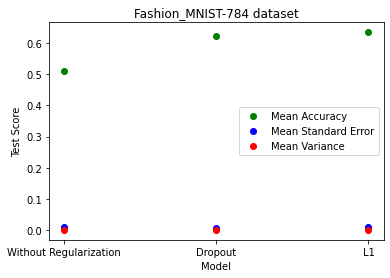

In [16]:
import numpy as np
import matplotlib.pyplot as plt

accuracy_base = np.array([55.73, 54.45, 47.89, 48.51, 52.09, 51.85, 55.01, 51.15, 46.88, 45.79])/100.0
mean_base = np.sum(accuracy_base)/accuracy_base.shape[0]
standard_dev_base = np.sqrt(np.sum((accuracy_base-mean_base)**2)/(accuracy_base.shape[0]-1.0))
standard_error_base = standard_dev_base/np.sqrt(accuracy_base.shape[0])
variance_base = standard_dev_base**2

accuracy_dropout = np.array([64.10, 62.14, 59.77, 60.25, 59.61, 62.99, 63.95, 59.11, 64.92, 65.19])/100.0
mean_L1 = np.sum(accuracy_dropout)/accuracy_dropout.shape[0]
standard_dev_L1 = np.sqrt(np.sum((accuracy_dropout-mean_L1)**2)/(accuracy_dropout.shape[0]-1.0))
standard_error_L1 = standard_dev_L1/np.sqrt(accuracy_dropout.shape[0])
variance_L1 = standard_dev_L1**2

accuracy_L1 = np.array([65.88, 60.33, 61.78, 59.97, 58.77, 66.29, 68.16, 67.01, 61.43, 64.67])/100.0
mean_L2 = np.sum(accuracy_L1)/accuracy_L1.shape[0]
standard_dev_L2 = np.sqrt(np.sum((accuracy_L1-mean_L2)**2)/(accuracy_L1.shape[0]-1.0))
standard_error_L2 = standard_dev_L2/np.sqrt(accuracy_L1.shape[0])
variance_L2 = standard_dev_L2**2


x = np.array([0,1,2])
y_mean = np.array([mean_base, mean_L1, mean_L2])
y_standard_error = np.array([standard_error_base, standard_error_L1, standard_error_L2])
y_variance = np.array([variance_base, variance_L1, variance_L2])

plt.figure(0)
my_xticks = ['Without Regularization','Dropout','L1']
plt.plot(x, y_mean, 'go', label='Mean Accuracy')
plt.plot(x, y_standard_error, 'bo', label='Mean Standard Error')
plt.plot(x, y_variance, 'ro', label='Mean Variance')
plt.xticks(x, my_xticks)
plt.xlabel('Model')
plt.ylabel('Test Score')
plt.title('Fashion_MNIST-784 dataset')
plt.legend()
plt.savefig('plot.jpg',dpi=200)

In [23]:
acct =[65.88, 60.33, 61.78, 59.97, 58.77, 66.29, 68.16, 67.01, 61.43, 64.67]


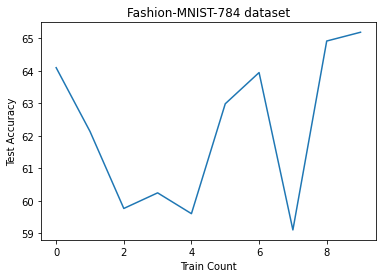

In [22]:
from matplotlib import pyplot as plt
plt.xlabel('Train Count')
plt.ylabel('Test Accuracy')
plt.title('Fashion-MNIST-784 dataset')
plt.plot(acct)
# plt.plot(loss)

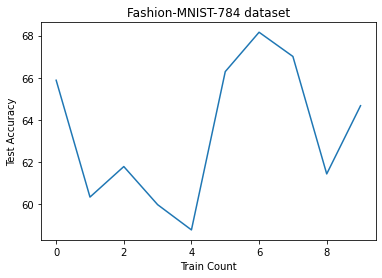

In [24]:
from matplotlib import pyplot as plt
plt.xlabel('Train Count')
plt.ylabel('Test Accuracy')
plt.title('Fashion-MNIST-784 dataset')
plt.plot(acct)
# plt.plot(loss)